# <font color='orange'>  <center> NLP Project: ML Algorithms on Text Data

## <font color='orange'> Each student must extract tweets from twitter. Perform pre-processing and text representation. Apply ML algorithms for classification/clustering. <br> <br> 1. Creating Datasets <dd> a. Extract 5000 tweets with any 5 search labels of your choice. (1000 each). Eg(#cricket, #football, #basketball, #tennis, #hockey). <dd> b. Create one dataset for all the tweets extracted along with labels as second column. Shuffle the dataset. </dd> <br> <br>2. Pre-processing <dd> a. Clean the data by removing tags, user handles, numbers, and other characters. <dd> b. Stem tokens for basic vectorization <dd> c. Lemma tokens for embeddings </dd> <br> <br> 3. Text representation <dd> a. Vectorise each document in the dataset with tf-idf vectorization with n-grams (use stemmed data). <dd> b. Create document embeddings by summation of word vectors taken from any two pre-trained models. The tokens must be lemmas. </dd> <br> <br> 4. Apply machine learning techniques (any two algorithms) for classification/clustering on <dd> a. 3.a data <dd> b. 3.b data </dd> <br> <br> 5. Evaluate the results (4.a and 4.b) which outperforms. <dd> a. For clustering compare at least 10 records’ label with the clusters created. <dd> b. Present a chart as for classification:

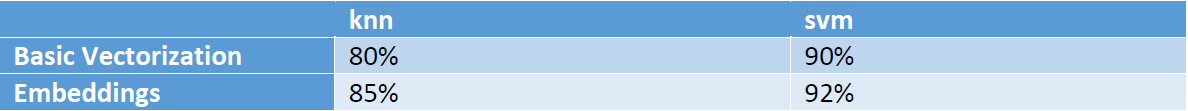

# <font color='orange'>  <center> Importing Libraries

In [199]:
import twitter_info

import tweepy
from imdb import IMDb

import time
import json
import pandas as pd
import numpy as np
from iteration_utilities import deepflatten
from datetime import datetime
import os
import re
import glob
from tqdm import tqdm

from nltk.tokenize import word_tokenize
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lm = WordNetLemmatizer()
from nltk.stem.porter import PorterStemmer
pm = PorterStemmer()
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.cluster import KMeans, DBSCAN

import codecs
from glove import Corpus, Glove
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models import FastText

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import silhouette_samples, silhouette_score

from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sn

from pickle import dump
from pickle import load

# <font color='orange'>  <center> Running all helper functions

In [2]:
%run helper_functions.ipynb

# <font color='orange'>  <center> Data Extraction

## <font color='orange'> Extracting Tweets

In [3]:
consumer_key = twitter_info.API_Key
consumer_secret = twitter_info.API_Key_Secret
access_token = twitter_info.Access_Token
access_token_secret = twitter_info.Access_Token_Secret
bearer_token = twitter_info.Bearer_Token

In [4]:
client = tweepy.Client(bearer_token = bearer_token)
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
API = tweepy.API(auth, wait_on_rate_limit=True, retry_count=5, retry_delay=180)

In [5]:
s = str(datetime.now())
s = s[:16].replace(" ", "_").replace(":","")

In [6]:
class_list = ['Star Wars','Marvel Cinematic Universe','MonsterVerse','Wizarding World','DC Extended Universe']
class_query_list = []
class_file_name = ['input/star_wars_keywords.txt', 'input/Marvel_Cinematic_Universe_MCU_keywords.txt', 
                   'input/MonsterVerse_keywords.txt', 'input/Wizarding_World_keywords.txt', 'input/DC_Extended_Universe_keywords.txt']
class_keyword_list = []
for i in range(len(class_list)):
    with open(class_file_name[i]) as f:
        class_keyword_list.append(f.readlines())
    class_keyword_list[i] = [key_word.strip() + ' OR ' for key_word in class_keyword_list[i]]
    class_temp = ''.join(class_keyword_list[i])
    class_query_list.append(class_temp[:-4])

In [7]:
for i in range(len(class_list)):
    print("\n", class_query_list[i], class_list[i], len(class_query_list[i]), "\n")


 "Star Wars" OR "Darth Vader" OR "Obi-Wan Kenobi" OR "Yoda" OR "Princess Leia" OR "R2-D2" OR "Chewbacca" OR "Darth Maul" OR "C-3PO" OR "Q ira" OR "Uncle Owen" OR "Admiral Ackbar" OR "Jabba Hut" OR "Skywalker" OR "A New Hope" OR "Empire Strikes Back" OR "Return Jedi" OR "Phantom Menace" OR "Attack Clones" OR "Revenge Sith" OR "Force Awakens" OR "Last Jedi" OR "Clone Wars" Star Wars 372 


 "Marvel Cinematic Universe" OR "MCU" OR "Thor" OR "Ant Man" OR "Falcon" OR "Hulk" OR "Luke Cage" OR "Doctor Strange" OR "Groot" OR "Punisher" OR "Black Widow" OR "Jessica Jones" OR "Dare devil" OR "Captain America" OR "Loki" OR "Black Panther" OR "Spider Man" OR "Iron Man" OR "Scarlet Witch" OR "Captain Marvel" OR "Hawkeye" OR "Star Lord" OR "Thanos" OR "Eternals" OR "The Avengers" OR "Guardians of the Galaxy" Marvel Cinematic Universe 413 


 "MonsterVerse" OR "King Kong" OR "Anguirus" OR "Godzilla" OR "MechaKing Ghidorah" OR "Mechagodzilla" OR "King Ghidorah" OR "MUTO" OR "Monster X" OR "Mothra" OR

In [8]:
important_key_words = []
for i in range(len(class_list)):
    with open(class_file_name[i]) as f:
        lines = f.readlines()
        lines = [l.split() for l in lines]
        important_key_words.extend(lines)
important_key_words = list(deepflatten(important_key_words, depth=1))
important_key_words = [k.strip('"') for k in important_key_words]
print(important_key_words[:10])

['Star', 'Wars', 'Darth', 'Vader', 'Obi-Wan', 'Kenobi', 'Yoda', 'Princess', 'Leia', 'R2-D2']


In [9]:
print(len(important_key_words))
txt = " ".join(important_key_words)
selected_tags = []
processed_key_words_stem = preprocess_doc(txt, stem=True, lemma=False, stop_wrds=True, selected_tags=selected_tags)
print(len(processed_key_words_stem))
print(processed_key_words_stem)

216
199
['star', 'war', 'darth', 'vader', 'obi-wan', 'kenobi', 'yoda', 'princess', 'leia', 'chewbacca', 'darth', 'maul', 'ira', 'uncl', 'owen', 'admir', 'ackbar', 'jabba', 'hut', 'skywalk', 'new', 'hope', 'empir', 'strike', 'back', 'return', 'jedi', 'phantom', 'menac', 'attack', 'clone', 'reveng', 'sith', 'forc', 'awaken', 'last', 'jedi', 'clone', 'war', 'marvel', 'cinemat', 'univers', 'mcu', 'thor', 'ant', 'man', 'falcon', 'hulk', 'luke', 'cage', 'doctor', 'strang', 'groot', 'punish', 'black', 'widow', 'jessica', 'jone', 'dare', 'devil', 'captain', 'america', 'loki', 'black', 'panther', 'spider', 'man', 'iron', 'man', 'scarlet', 'witch', 'captain', 'marvel', 'hawkey', 'star', 'lord', 'thano', 'etern', 'aveng', 'guardian', 'galaxi', 'monstervers', 'king', 'kong', 'anguiru', 'godzilla', 'mechak', 'ghidorah', 'mechagodzilla', 'king', 'ghidorah', 'muto', 'monster', 'mothra', 'preston', 'packard', 'alan', 'jonah', 'emma', 'russel', 'mark', 'russel', 'jame', 'conrad', 'mason', 'weaver', 'fo

In [10]:
print(len(important_key_words))
txt = " ".join(important_key_words)
selected_tags = []
processed_key_words_lemma = preprocess_doc(txt, stem=False, lemma=True, stop_wrds=True, selected_tags=selected_tags)
print(len(processed_key_words_lemma))
print(processed_key_words_lemma)

216
199
['star', 'war', 'darth', 'vader', 'obi-wan', 'kenobi', 'yoda', 'princess', 'leia', 'chewbacca', 'darth', 'maul', 'ira', 'uncle', 'owen', 'admiral', 'ackbar', 'jabba', 'hut', 'skywalker', 'new', 'hope', 'empire', 'strike', 'back', 'return', 'jedi', 'phantom', 'menace', 'attack', 'clone', 'revenge', 'sith', 'force', 'awakens', 'last', 'jedi', 'clone', 'war', 'marvel', 'cinematic', 'universe', 'mcu', 'thor', 'ant', 'man', 'falcon', 'hulk', 'luke', 'cage', 'doctor', 'strange', 'groot', 'punisher', 'black', 'widow', 'jessica', 'jones', 'dare', 'devil', 'captain', 'america', 'loki', 'black', 'panther', 'spider', 'man', 'iron', 'man', 'scarlet', 'witch', 'captain', 'marvel', 'hawkeye', 'star', 'lord', 'thanos', 'eternals', 'avenger', 'guardian', 'galaxy', 'monsterverse', 'king', 'kong', 'anguirus', 'godzilla', 'mechaking', 'ghidorah', 'mechagodzilla', 'king', 'ghidorah', 'muto', 'monster', 'mothra', 'preston', 'packard', 'alan', 'jonah', 'emma', 'russell', 'mark', 'russell', 'james', 

In [11]:
%%time
for i in range(len(class_list)):
    print("\n", class_query_list[i], class_list[i], "\n")
    extract_tweets(class_query_list[i], class_list[i], fresh_load = False)


 "Star Wars" OR "Darth Vader" OR "Obi-Wan Kenobi" OR "Yoda" OR "Princess Leia" OR "R2-D2" OR "Chewbacca" OR "Darth Maul" OR "C-3PO" OR "Q ira" OR "Uncle Owen" OR "Admiral Ackbar" OR "Jabba Hut" OR "Skywalker" OR "A New Hope" OR "Empire Strikes Back" OR "Return Jedi" OR "Phantom Menace" OR "Attack Clones" OR "Revenge Sith" OR "Force Awakens" OR "Last Jedi" OR "Clone Wars" Star Wars 

Tweets extracted in output/tweets/ folder

 "Marvel Cinematic Universe" OR "MCU" OR "Thor" OR "Ant Man" OR "Falcon" OR "Hulk" OR "Luke Cage" OR "Doctor Strange" OR "Groot" OR "Punisher" OR "Black Widow" OR "Jessica Jones" OR "Dare devil" OR "Captain America" OR "Loki" OR "Black Panther" OR "Spider Man" OR "Iron Man" OR "Scarlet Witch" OR "Captain Marvel" OR "Hawkeye" OR "Star Lord" OR "Thanos" OR "Eternals" OR "The Avengers" OR "Guardians of the Galaxy" Marvel Cinematic Universe 

Tweets extracted in output/tweets/ folder

 "MonsterVerse" OR "King Kong" OR "Anguirus" OR "Godzilla" OR "MechaKing Ghidorah" O

In [12]:
df_all_tweet_list = []
class_output_files = []
list_output_files = [os.getcwd()+"\\output\\tweets\\"+f for f in os.listdir("output/tweets/")]
def find_label(file_name):
    for c in class_list:
        if(file_name.find(c) >= 0):
            return c
    return None
for f in list_output_files:
    class_output_files.append([find_label(f), f])
class_output_files

[['DC Extended Universe',
  'C:\\spark\\MCA\\Semester 1\\E3_NLP\\Case_Study\\output\\tweets\\nlp_tweet_DC Extended Universe_2022-04-05_0332.csv'],
 ['Marvel Cinematic Universe',
  'C:\\spark\\MCA\\Semester 1\\E3_NLP\\Case_Study\\output\\tweets\\nlp_tweet_Marvel Cinematic Universe_2022-04-05_0332.csv'],
 ['MonsterVerse',
  'C:\\spark\\MCA\\Semester 1\\E3_NLP\\Case_Study\\output\\tweets\\nlp_tweet_MonsterVerse_2022-04-05_0332.csv'],
 ['Star Wars',
  'C:\\spark\\MCA\\Semester 1\\E3_NLP\\Case_Study\\output\\tweets\\nlp_tweet_Star Wars_2022-04-05_0332.csv'],
 ['Wizarding World',
  'C:\\spark\\MCA\\Semester 1\\E3_NLP\\Case_Study\\output\\tweets\\nlp_tweet_Wizarding World_2022-04-05_0332.csv']]

In [13]:
def get_full_text(label, file_name):
    df_temp = pd.read_csv(file_name)
    df_temp['label'] = label
    return df_temp[['full_text','label']]
class_tweet_list = []
for val in class_output_files:
    df_tweet_label = get_full_text(val[0], val[1])
    class_tweet_list.append(df_tweet_label)

In [14]:
final_tweet_df = pd.concat(class_tweet_list, axis=0, ignore_index=True)
final_tweet_df.to_csv("output/final_output/full_tweet_list.csv", index = False)
final_tweet_df

,full_text,label
0,Barnes &amp; Noble Pickup\n\nBarnes and Noble ...,DC Extended Universe
1,The True Crime Podcasts in the Batman universe...,DC Extended Universe
2,Want a free December's Dream Set!?❄🎀\nFollow m...,DC Extended Universe
3,I'm about to put some of my original artwork u...,DC Extended Universe
4,@Darmson2 @ALMUBAR04 @MUFC_Boogie @king_polams...,DC Extended Universe
...,...,...
49795,@essteeem Harry Potter movie series,Wizarding World
49796,my heart aches reminiscing ot/12 era (minus vo...,Wizarding World
49797,@bfsnailea Harry Potter,Wizarding World
49798,Next. #Hogwartle 92 3/6\n\n⬜⬜⬜⬜⬜\n🟩🟩⬜⬜⬜\n🟩🟩🟩🟩🟩...,Wizarding World


## <font color='orange'> Extracting IMDB Reviews

In [15]:
df_movies_id = pd.read_csv("input/imdb_movie_list.csv")
df_movies_id

,Universe,Movie_Name,IMDB_Movie_Id,Movie_Name_Key
0,Star Wars,A New Hope,76759,star_wars_a_new_hope
1,Star Wars,The Empire Strikes Back,80684,star_wars_the_empire_strikes_back
2,Star Wars,Return of the Jedi,86190,star_wars_episode_vi_return_of_the_jedi
3,Star Wars,The Phantom Menace,120915,star_wars_episode_i_the_phantom_menace
4,Star Wars,Attack of the Clones,121765,star_wars_episode_ii_attack_of_the_clones
...,...,...,...,...
59,Wizarding World,Harry Potter and the Half-Blood Prince,417741,harry_potter_and_the_half_blood_prince
60,Wizarding World,Harry Potter and the Deathly Hallows – Part 1,926084,harry_potter_and_the_deathly_hallows_part_1
61,Wizarding World,Harry Potter and the Deathly Hallows – Part 2,1201607,harry_potter_and_the_deathly_hallows_part_2
62,Wizarding World,Fantastic Beasts and Where to Find Them,3183660,fantastic_beasts_and_where_to_find_them


In [16]:
fresh_load=False
extract_imdb_reviews(df_movies_id, fresh_load)

Extracted IMDB reviews to output/final_output/full_imdb_review_list.csv


In [17]:
final_imdb_df = pd.read_csv("output/final_output/full_imdb_review_list.csv")
final_imdb_df.head()

,full_text,label
0,Henry Cavil is my Superman. He's the best Supe...,DC Extended Universe
1,"A QUICK "" DVD-REVIEW "" .HENRY CAVILL ⭐ CARRIES...",DC Extended Universe
2,Hands down the best Superman movie out there. ...,DC Extended Universe
3,At first I was very nervous at the prospect of...,DC Extended Universe
4,So we are looking at essentially a remake of S...,DC Extended Universe


In [18]:
final_input_df = pd.concat([final_imdb_df,final_tweet_df], axis=0, ignore_index=True)
final_input_df = final_input_df.sample(frac=1, random_state=42).reset_index(drop=True)    ## Shuffling Dataframe
final_input_df.to_csv("output/final_output/final_input_df.csv", index = False)

In [19]:
final_input_df = pd.read_csv("output/final_output/final_input_df.csv")
final_input_df

,full_text,label
0,‘#GuardiansoftheGalaxy 3’ Star #KarenGillan Sa...,Marvel Cinematic Universe
1,My friend recommend me a few shows and I have ...,DC Extended Universe
2,@Papa__Drago Godzilla would win easily but jus...,MonsterVerse
3,Batman &amp; Robin...It's so camp https://t.co...,DC Extended Universe
4,why is huge ant man moving so slow,Marvel Cinematic Universe
...,...,...
51457,@tortoisethatwon @aightmoe @Sarcasm_bender End...,DC Extended Universe
51458,@iHrtProngs SIRIUS BLACK DOES NOT HAVE A BAD H...,Wizarding World
51459,@aNorthernGarden @fiona_skywalker Agreed. She ...,Star Wars
51460,And so my long Marvel-watching journey comes t...,Marvel Cinematic Universe


In [20]:
final_input_df['label'].value_counts()

Marvel Cinematic Universe    10701
Wizarding World              10260
Star Wars                    10211
DC Extended Universe         10186
MonsterVerse                 10104
Name: label, dtype: int64

# <font color='orange'>  <center> Text Pre-processing

In [21]:
tags = nltk.data.load('help/tagsets/upenn_tagset.pickle')
#nltk.help.upenn_tagset()
#selected_tags = ['NN','NNP','NNPS','NNS','JJ','JJR','JJS']
selected_tags = ['NN','NNP','NNPS','NNS']

In [22]:
sample_text = final_input_df['full_text'][2]
print(pos_tag(word_tokenize(sample_text)))
print(sample_text)
sample_text = preprocess_doc(sample_text, False, True, True, selected_tags)
print(sample_text)

[('@', 'NN'), ('Papa__Drago', 'NNP'), ('Godzilla', 'NNP'), ('would', 'MD'), ('win', 'VB'), ('easily', 'RB'), ('but', 'CC'), ('just', 'RB'), ('seeing', 'VBG'), ('him', 'PRP'), ('tear', 'VB'), ('through', 'IN'), ('hundreds', 'NNS'), ('of', 'IN'), ('titans', 'NNS'), ('WOULD', 'NNP'), ('BE', 'NNP'), ('SO', 'NNP'), ('FREAKING', 'NNP'), ('COOL', 'NNP'), ('!', '.'), ('OMG', 'NN')]
@Papa__Drago Godzilla would win easily but just seeing him tear through hundreds of titans WOULD BE SO FREAKING COOL! OMG
['papa', 'drago', 'godzilla', 'titan', 'omg']


## <font color='orange'> Cleaning, Stemming and Lemmatizing Texts

In [23]:
extract_stems_lemma(selected_tags, final_input_df, fresh_load= False)

Stems and Lemma extracted to output/final_output/final_input_cleaned_stem_lemma.csv


In [24]:
final_input_df = pd.read_csv("output/final_output/final_input_cleaned_stem_lemma.csv")

In [25]:
final_input_df['label_id'] = final_input_df['label'].astype("category").cat.codes
final_input_df

,full_text,label,stem_cleaned_tokens,lemma_cleaned_tokens,label_id
0,‘#GuardiansoftheGalaxy 3’ Star #KarenGillan Sa...,Marvel Cinematic Universe,"['guardiansofthegalaxi', 'star', 'karengillan'...","['guardiansofthegalaxy', 'star', 'karengillan'...",1
1,My friend recommend me a few shows and I have ...,DC Extended Universe,"['friend', 'show', 'idea', 'flash', 'guy', 'sh...","['friend', 'show', 'idea', 'flash', 'guy', 'sh...",0
2,@Papa__Drago Godzilla would win easily but jus...,MonsterVerse,"['papa', 'drago', 'godzilla', 'hundr', 'titan'...","['papa', 'drago', 'godzilla', 'titan', 'omg']",2
3,Batman &amp; Robin...It's so camp https://t.co...,DC Extended Universe,"['batman', 'robin', 'camp']","['batman', 'robin', 'camp']",0
4,why is huge ant man moving so slow,Marvel Cinematic Universe,"['ant', 'man', 'move']","['ant', 'man']",1
...,...,...,...,...,...
51457,@tortoisethatwon @aightmoe @Sarcasm_bender End...,DC Extended Universe,"['tortoisethatwon', 'aightmo', 'sarcasm', 'ben...","['tortoisethatwon', 'aightmoe', 'sarcasm', 'be...",0
51458,@iHrtProngs SIRIUS BLACK DOES NOT HAVE A BAD H...,Wizarding World,"['hair', 'day']","['ihrtprongs', 'hair', 'day']",4
51459,@aNorthernGarden @fiona_skywalker Agreed. She ...,Star Wars,"['fiona', 'skywalk', 'liter', 'ask', 'comment'...","['fiona', 'skywalker', 'input', 'earns', 'hous...",3
51460,And so my long Marvel-watching journey comes t...,Marvel Cinematic Universe,"['marvel-watch', 'journey', 'caught', 'endless...","['journey', 'end', 'franchise', 'eon', 'rest',...",1


In [26]:
df_vectorization = final_input_df[['stem_cleaned_tokens', 'label', 'label_id']]
df_vectorization.head()

,stem_cleaned_tokens,label,label_id
0,"['guardiansofthegalaxi', 'star', 'karengillan'...",Marvel Cinematic Universe,1
1,"['friend', 'show', 'idea', 'flash', 'guy', 'sh...",DC Extended Universe,0
2,"['papa', 'drago', 'godzilla', 'hundr', 'titan'...",MonsterVerse,2
3,"['batman', 'robin', 'camp']",DC Extended Universe,0
4,"['ant', 'man', 'move']",Marvel Cinematic Universe,1


In [27]:
dfvg = df_vectorization.groupby(['label', 'label_id'])
classes = {}
for d in dfvg:
    classes[d[0][1]] = d[0][0]
print(classes)

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}


In [28]:
df_embedding = final_input_df[['lemma_cleaned_tokens', 'label', 'label_id']]
df_embedding.head()

,lemma_cleaned_tokens,label,label_id
0,"['guardiansofthegalaxy', 'star', 'karengillan'...",Marvel Cinematic Universe,1
1,"['friend', 'show', 'idea', 'flash', 'guy', 'sh...",DC Extended Universe,0
2,"['papa', 'drago', 'godzilla', 'titan', 'omg']",MonsterVerse,2
3,"['batman', 'robin', 'camp']",DC Extended Universe,0
4,"['ant', 'man']",Marvel Cinematic Universe,1


In [29]:
df_embedding.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51462 entries, 0 to 51461
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   lemma_cleaned_tokens  51462 non-null  object
 1   label                 51462 non-null  object
 2   label_id              51462 non-null  int8  
dtypes: int8(1), object(2)
memory usage: 854.5+ KB


In [30]:
df_vectorization.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51462 entries, 0 to 51461
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   stem_cleaned_tokens  51462 non-null  object
 1   label                51462 non-null  object
 2   label_id             51462 non-null  int8  
dtypes: int8(1), object(2)
memory usage: 854.5+ KB


In [31]:
df_vectorization = df_vectorization.drop_duplicates(subset='stem_cleaned_tokens', keep="first")
df_vectorization = df_vectorization.reset_index(drop=True)
df_embedding = df_embedding.drop_duplicates(subset='lemma_cleaned_tokens', keep="first")
df_embedding = df_embedding.reset_index(drop=True)

In [32]:
'''list_stemmed_data = []
list_embedding_data = []
for i in df_vectorization.index:
    exec("lst = " + df_vectorization['stem_cleaned_tokens'][i])
    lst = clean_tokens(lst)
    list_stemmed_data.append(" ".join(lst))
    exec("lst2 = " + df_embedding['lemma_cleaned_tokens'][i])
    lst2 = clean_tokens(lst2)
    list_embedding_data.append(" ".join(lst2))'''

'list_stemmed_data = []\nlist_embedding_data = []\nfor i in df_vectorization.index:\n    exec("lst = " + df_vectorization[\'stem_cleaned_tokens\'][i])\n    lst = clean_tokens(lst)\n    list_stemmed_data.append(" ".join(lst))\n    exec("lst2 = " + df_embedding[\'lemma_cleaned_tokens\'][i])\n    lst2 = clean_tokens(lst2)\n    list_embedding_data.append(" ".join(lst2))'

In [33]:
%%time
list_stemmed_data = []
list_embedding_data = []
drop_stemmed_index = []
drop_lemma_index = []
for i in df_vectorization.index:
    exec("lst = " + df_vectorization['stem_cleaned_tokens'][i])
    lst = clean_tokens(lst)
    if(len(lst) == 0 or lst[0] == ''):
        drop_stemmed_index.append(i)
    list_stemmed_data.append(" ".join(lst))
for i in df_embedding.index:
    exec("lst2 = " + df_embedding['lemma_cleaned_tokens'][i])
    lst2 = clean_tokens(lst2)
    if(len(lst2) == 0 or lst2[0] == ''):
         drop_lemma_index.append(i)
    list_embedding_data.append(" ".join(lst2))

CPU times: total: 6.27 s
Wall time: 6.27 s


In [34]:
df_vectorization.drop(index=drop_stemmed_index, inplace = True)
df_vectorization = df_vectorization.reset_index(drop=True)
df_embedding.drop(index=drop_lemma_index, inplace = True)
df_embedding = df_embedding.reset_index(drop=True)
for i in drop_stemmed_index:
    del list_stemmed_data[i]
for i in drop_lemma_index:
    del list_embedding_data[i]

In [35]:
len(df_vectorization), len(list_stemmed_data)

(47348, 47348)

In [36]:
len(df_embedding), len(list_embedding_data)

(46683, 46683)

In [37]:
df_vectorization['label'].value_counts()

Marvel Cinematic Universe    10098
DC Extended Universe          9558
MonsterVerse                  9388
Star Wars                     9195
Wizarding World               9109
Name: label, dtype: int64

In [38]:
df_vectorization.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47348 entries, 0 to 47347
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   stem_cleaned_tokens  47348 non-null  object
 1   label                47348 non-null  object
 2   label_id             47348 non-null  int8  
dtypes: int8(1), object(2)
memory usage: 786.2+ KB


In [39]:
df_embedding.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46683 entries, 0 to 46682
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   lemma_cleaned_tokens  46683 non-null  object
 1   label                 46683 non-null  object
 2   label_id              46683 non-null  int8  
dtypes: int8(1), object(2)
memory usage: 775.1+ KB


# <font color='orange'>  <center> TF-IDF Vectorization

In [40]:
%%time
tf_idf_vectorizer = TfidfVectorizer(ngram_range = (1,3), analyzer='word', min_df=2)
vectorized_text=tf_idf_vectorizer.fit_transform(list_stemmed_data)

CPU times: total: 2.22 s
Wall time: 2.27 s


In [41]:
tf_idf_vectors = tf_idf_vectorizer.get_feature_names_out()
tf_idf_vectors

array(['abaddon', 'abaga', 'abaga eniolamaf', ..., 'zuri whitak',
       'zxshadowacexz', 'zypisfi'], dtype=object)

In [42]:
len(tf_idf_vectors)

77023

In [43]:
dump(tf_idf_vectorizer,open('models/tfidf_stem_vector.pkl', 'wb'))

In [44]:
tf_idf_vectorizer = load(open('models/tfidf_stem_vector.pkl', 'rb'))

## <font color='orange'> Splitting TFIDF vectors into Train and Validation datasets

In [45]:
%%time
X_sv=vectorized_text
y_sv=list(df_vectorization['label_id'])
print(X_sv.shape)
print(len(y_sv))
X_train_sv, X_valid_sv, y_train_sv, y_valid_sv = train_test_split(X_sv, y_sv, test_size = 0.3, shuffle = True, stratify = y_sv, random_state = 3)

(47348, 77023)
47348
CPU times: total: 31.2 ms
Wall time: 37 ms


# <font color='orange'>  <center> TFIDF Multinomial Naive Bayes model

Train Accuracy Score of TFIDF Multinomial Naive Bayes model created using stemmed tf_idf vector is:
 0.9637932595118125
------------------------------------------------------------------------------------------------------------------------
Validation Accuracy Score of TFIDF Multinomial Naive Bayes model created using stemmed tf_idf vector is:
 0.9151003167898627
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:


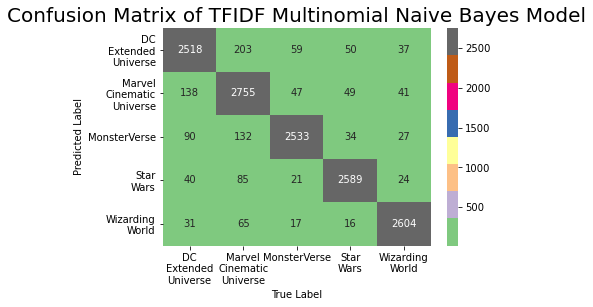

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
                           precision    recall  f1-score   support

     DC Extended Universe       0.89      0.88      0.89      2867
Marvel Cinematic Universe       0.85      0.91      0.88      3030
             MonsterVerse       0.95      0.90      0.92      2816
                Star Wars       0.95      0.94      0.94      2759
          Wizarding World       0.95      0.95      0.95      2733

                 accuracy                           0.92     14205
                macro avg       0.92      0.92      0.92     14205
             weighted avg       0.92      0.92      0.92     14205

CPU times: total: 422 ms
Wall time: 805 ms


In [46]:
%%time
tfidf_mnb_model = MultinomialNB()
tfidf_mnb_model, score_tfidf_mnb = evaluate_model(X_train_sv, y_train_sv, X_valid_sv, y_valid_sv, classes, 
                                         tfidf_mnb_model, "TFIDF Multinomial Naive Bayes", "tfidf_mnb_model.pkl", fresh_load=False)

In [47]:
get_cross_val(tfidf_mnb_model, X_train_sv, y_train_sv, X_valid_sv, y_valid_sv)

Cross validation over 10 folds:  0.9147329169818432


array([2, 4, 1, ..., 1, 0, 0])

In [48]:
tf_idf_vectorizer = load(open('models/tfidf_stem_vector.pkl', 'rb'))
tfidf_mnb_model = load(open('models/tfidf_mnb_model.pkl', 'rb'))

In [49]:
output_file_name = "input/rottentomatoes_reviews_final.csv"
df_rottentomatoes_reviews = pd.read_csv(output_file_name)

In [50]:
df_rottentomatoes_reviews[["review", "label_name"]]

,review,label_name
0,"2019's Godzilla: King of the Monsters, does pr...",MonsterVerse
1,"Shazam!, it's wonderful. It's a very well-dire...",DC Extended Universe
2,The crimes of Grindelwald is a very good film ...,Wizarding World
3,An entertaining film with a great villain and ...,Marvel Cinematic Universe
4,Captain America: Civil War goes a darker direc...,Marvel Cinematic Universe
...,...,...
260,Shazam is fun and entertaining! It succeeds in...,DC Extended Universe
261,Godzilla: King of the Monsters was the first M...,MonsterVerse
262,"Not quite top tier MCU, but very close. This i...",Marvel Cinematic Universe
263,There are a lot of mixed feeling about this mo...,Marvel Cinematic Universe


In [51]:
%%time
classes = {0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
test_tfidf_vec_list = []
for i in df_rottentomatoes_reviews.index:
    test_text = df_rottentomatoes_reviews["review"][i]
    test_text = preprocess_doc(test_text, stem = True, lemma = False, stop_wrds = True, selected_tags = selected_tags)
    vec = tf_idf_vectorizer.transform(test_text)
    test_tfidf_vec_list.append(vec)

CPU times: total: 11 s
Wall time: 11 s


In [52]:
%%time
test_acc_scr_tfidf_mnb, df_rottentomatoes_reviews = test_model(tfidf_mnb_model, "TFIDF Multinomial Naive Bayes", "tfidf_MNB", df_rottentomatoes_reviews, test_tfidf_vec_list)

Test Accuracy Score of TFIDF Multinomial Naive Bayes Model created using stemmed tf_idf vector is:
 0.7283018867924528
CPU times: total: 438 ms
Wall time: 445 ms


In [53]:
df_rottentomatoes_reviews.to_csv("output/final_output/df_rottentomatoes_reviews_predicted"+s+".csv", index = False)
df_rottentomatoes_reviews

,review,movie_name,label_name,predicted_label_MNB,y_true,y_pred_MNB,predicted_label_tfidf_rfc,y_pred_tfidf_rfc,predicted_label_tfidf_MNB,y_pred_tfidf_MNB
0,"2019's Godzilla: King of the Monsters, does pr...",godzilla_king_of_the_monsters_2019,MonsterVerse,MonsterVerse,2,2,MonsterVerse,2,MonsterVerse,2
1,"Shazam!, it's wonderful. It's a very well-dire...",shazam,DC Extended Universe,DC Extended Universe,0,0,DC Extended Universe,0,Marvel Cinematic Universe,1
2,The crimes of Grindelwald is a very good film ...,fantastic_beasts_the_crimes_of_grindelwald,Wizarding World,Wizarding World,4,4,MonsterVerse,2,DC Extended Universe,0
3,An entertaining film with a great villain and ...,spider_man_homecoming,Marvel Cinematic Universe,Marvel Cinematic Universe,1,1,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1
4,Captain America: Civil War goes a darker direc...,captain_america_civil_war,Marvel Cinematic Universe,Marvel Cinematic Universe,1,1,Marvel Cinematic Universe,1,Marvel Cinematic Universe,1
...,...,...,...,...,...,...,...,...,...,...
260,Shazam is fun and entertaining! It succeeds in...,shazam,DC Extended Universe,DC Extended Universe,0,0,DC Extended Universe,0,DC Extended Universe,0
261,Godzilla: King of the Monsters was the first M...,godzilla_king_of_the_monsters_2019,MonsterVerse,MonsterVerse,2,2,MonsterVerse,2,MonsterVerse,2
262,"Not quite top tier MCU, but very close. This i...",avengers_infinity_war,Marvel Cinematic Universe,Marvel Cinematic Universe,1,1,DC Extended Universe,0,Marvel Cinematic Universe,1
263,There are a lot of mixed feeling about this mo...,thor_the_dark_world,Marvel Cinematic Universe,Marvel Cinematic Universe,1,1,DC Extended Universe,0,Marvel Cinematic Universe,1


# <font color='orange'>  <center> TFIDF Support Vector Classifier

Train Accuracy Score of TFIDF Support Vector Classifier model created using stemmed tf_idf vector is:
 0.9936939926983074
------------------------------------------------------------------------------------------------------------------------
Validation Accuracy Score of TFIDF Support Vector Classifier model created using stemmed tf_idf vector is:
 0.9154523055262231
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:


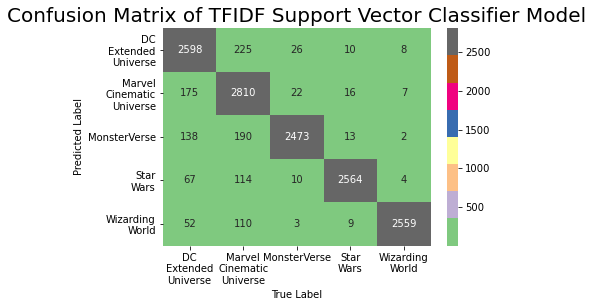

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
                           precision    recall  f1-score   support

     DC Extended Universe       0.86      0.91      0.88      2867
Marvel Cinematic Universe       0.81      0.93      0.87      3030
             MonsterVerse       0.98      0.88      0.92      2816
                Star Wars       0.98      0.93      0.95      2759
          Wizarding World       0.99      0.94      0.96      2733

                 accuracy                           0.92     14205
                macro avg       0.92      0.92      0.92     14205
             weighted avg       0.92      0.92      0.92     14205

CPU times: total: 2min
Wall time: 2min 1s


In [54]:
%%time
tfidf_svc_model = SVC()
tfidf_svc_model, score_tfidf_svc = evaluate_model(X_train_sv, y_train_sv, X_valid_sv, y_valid_sv, classes, 
                                         tfidf_svc_model, "TFIDF Support Vector Classifier", "tfidf_svc_model.pkl", fresh_load=False)

In [55]:
tf_idf_vectorizer = load(open('models/tfidf_stem_vector.pkl', 'rb'))
tfidf_svc_model = load(open('models/tfidf_svc_model.pkl', 'rb'))

In [56]:
list_f = sorted(glob.glob("output/final_output/df_rottentomatoes_reviews_predicted*"), key=os.path.getmtime)
output_file_name = list_f[0]
df_rottentomatoes_reviews = pd.read_csv(output_file_name)

In [57]:
%%time
test_acc_scr_tfidf_svc, df_rottentomatoes_reviews = test_model(tfidf_svc_model, "TFIDF Support Vector Classifier", "tfidf_svc", df_rottentomatoes_reviews, test_tfidf_vec_list)

Test Accuracy Score of TFIDF Support Vector Classifier Model created using stemmed tf_idf vector is:
 0.6566037735849056
CPU times: total: 14.7 s
Wall time: 14.7 s


In [58]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

# <font color='orange'>  <center> TFIDF KNN Classifier

Train Accuracy Score of TFIDF K-Nearest Neighbor(KNN) model created using stemmed tf_idf vector is:
 0.6122861539389917
------------------------------------------------------------------------------------------------------------------------
Validation Accuracy Score of TFIDF K-Nearest Neighbor(KNN) model created using stemmed tf_idf vector is:
 0.42133051742344246
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:


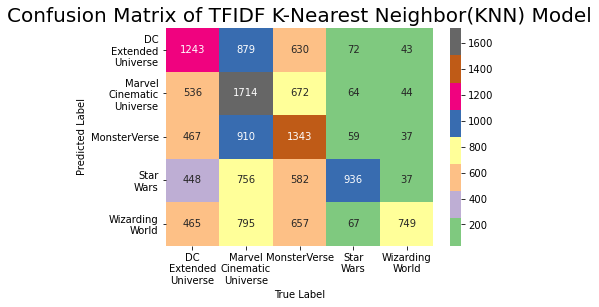

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
                           precision    recall  f1-score   support

     DC Extended Universe       0.39      0.43      0.41      2867
Marvel Cinematic Universe       0.34      0.57      0.42      3030
             MonsterVerse       0.35      0.48      0.40      2816
                Star Wars       0.78      0.34      0.47      2759
          Wizarding World       0.82      0.27      0.41      2733

                 accuracy                           0.42     14205
                macro avg       0.54      0.42      0.42     14205
             weighted avg       0.53      0.42      0.42     14205

CPU times: total: 52.1 s
Wall time: 52.3 s


In [59]:
%%time
tfidf_knn_model = KNeighborsClassifier(5)
tfidf_knn_model, score_tfidf_knn = evaluate_model(X_train_sv, y_train_sv, X_valid_sv, y_valid_sv, classes, 
                                         tfidf_knn_model, "TFIDF K-Nearest Neighbor(KNN)", "tfidf_knn_model.pkl", fresh_load=False)

In [60]:
tf_idf_vectorizer = load(open('models/tfidf_stem_vector.pkl', 'rb'))
tfidf_knn_model = load(open('models/tfidf_knn_model.pkl', 'rb'))

In [61]:
list_f = sorted(glob.glob("output/final_output/df_rottentomatoes_reviews_predicted*"), key=os.path.getmtime)
output_file_name = list_f[0]
df_rottentomatoes_reviews = pd.read_csv(output_file_name)

In [62]:
%%time
test_acc_scr_tfidf_knn, df_rottentomatoes_reviews = test_model(tfidf_knn_model, "TFIDF K-Nearest Neighbor(KNN)", "tfidf_knn", df_rottentomatoes_reviews, test_tfidf_vec_list)

Test Accuracy Score of TFIDF K-Nearest Neighbor(KNN) Model created using stemmed tf_idf vector is:
 0.5132075471698113
CPU times: total: 12.4 s
Wall time: 12.4 s


In [63]:
#%%time
#get_cross_val(tfidf_knn_model, X_train_sv, y_train_sv, X_valid_sv, y_valid_sv)

In [64]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

# <font color='orange'>  <center> TFIDF Random Forest Classifier

------------------------------------------------------------------------------------------------------------------------
Train Accuracy Score of TFIDF Random Forest Classifier model created using stemmed tf_idf vector is:
 0.9973146667471261
------------------------------------------------------------------------------------------------------------------------
Validation Accuracy Score of TFIDF Random Forest Classifier model created using stemmed tf_idf vector is:
 0.9182682154171067
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:


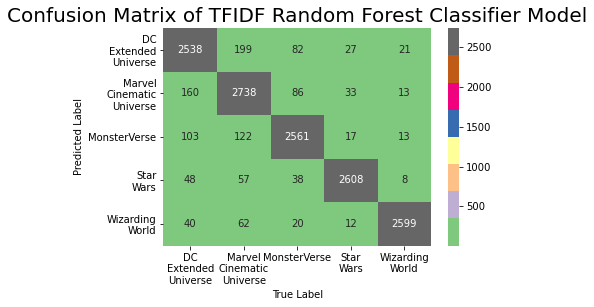

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
                           precision    recall  f1-score   support

     DC Extended Universe       0.88      0.89      0.88      2867
Marvel Cinematic Universe       0.86      0.90      0.88      3030
             MonsterVerse       0.92      0.91      0.91      2816
                Star Wars       0.97      0.95      0.96      2759
          Wizarding World       0.98      0.95      0.96      2733

                 accuracy                           0.92     14205
                macro avg       0.92      0.92      0.92     14205
             weighted avg       0.92      0.92      0.92     14205

CPU times: total: 10min 45s
Wall time: 10min 47s


In [136]:
%%time
tfidf_rndm_frst_model = RandomForestClassifier(n_estimators=200)
tfidf_rndm_frst_model, score_tfidf_rfc = evaluate_model(X_train_sv, y_train_sv, X_valid_sv, y_valid_sv, classes, 
                                         tfidf_rndm_frst_model, "TFIDF Random Forest Classifier", "tfidf_rndm_frst_model.pkl", fresh_load=True)

In [137]:
tf_idf_vectorizer = load(open('models/tfidf_stem_vector.pkl', 'rb'))
tfidf_rndm_frst_model = load(open('models/tfidf_rndm_frst_model.pkl', 'rb'))

In [138]:
list_f = sorted(glob.glob("output/final_output/df_rottentomatoes_reviews_predicted*"), key=os.path.getmtime)
output_file_name = list_f[0]
df_rottentomatoes_reviews = pd.read_csv(output_file_name)

In [139]:
%%time
test_acc_scr_tfidf_rfc, df_rottentomatoes_reviews = test_model(tfidf_rndm_frst_model, "TFIDF Random Forest Classifier", "tfidf_rfc", df_rottentomatoes_reviews, test_tfidf_vec_list)

Test Accuracy Score of TFIDF Random Forest Classifier Model created using stemmed tf_idf vector is:
 0.4188679245283019
CPU times: total: 42.7 s
Wall time: 42.8 s


In [140]:
#%%time
#get_cross_val(tfidf_rndm_frst_model, X_train_sv, y_train_sv, X_valid_sv, y_valid_sv)

In [141]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

# <font color='orange'>  <center> TFIDF XG-Boost Classifier

------------------------------------------------------------------------------------------------------------------------
Train Accuracy Score of TFIDF XGB Classifier model created using stemmed tf_idf vector is:
 0.931478743626105
------------------------------------------------------------------------------------------------------------------------
Validation Accuracy Score of TFIDF XGB Classifier model created using stemmed tf_idf vector is:
 0.9098908834917283
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:


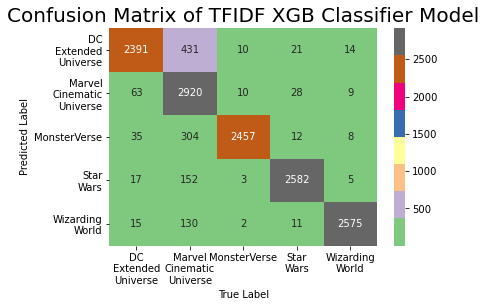

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
                           precision    recall  f1-score   support

     DC Extended Universe       0.95      0.83      0.89      2867
Marvel Cinematic Universe       0.74      0.96      0.84      3030
             MonsterVerse       0.99      0.87      0.93      2816
                Star Wars       0.97      0.94      0.95      2759
          Wizarding World       0.99      0.94      0.96      2733

                 accuracy                           0.91     14205
                macro avg       0.93      0.91      0.91     14205
             weighted avg       0.92      0.91      0.91     14205

CPU times: total: 12min 35s
Wall time: 1min 40s


In [71]:
%%time
tfidf_xgb_model = xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=200,
        use_label_encoder=False,
        eval_metric='auc')
tfidf_xgb_model, score_tfidf_xgb = evaluate_model(X_train_sv, y_train_sv, X_valid_sv, y_valid_sv, classes, 
                                         tfidf_xgb_model, "TFIDF XGB Classifier", "tfidf_xgb_model.pkl", fresh_load=True)

In [72]:
tf_idf_vectorizer = load(open('models/tfidf_stem_vector.pkl', 'rb'))
tfidf_xgb_model = load(open('models/tfidf_xgb_model.pkl', 'rb'))

In [73]:
list_f = sorted(glob.glob("output/final_output/df_rottentomatoes_reviews_predicted*"), key=os.path.getmtime)
output_file_name = list_f[0]
df_rottentomatoes_reviews = pd.read_csv(output_file_name)

In [74]:
%%time
test_acc_scr_tfidf_xgb, df_rottentomatoes_reviews = test_model(tfidf_xgb_model, "TFIDF XGB Classifier", "tfidf_xgb", df_rottentomatoes_reviews, test_tfidf_vec_list)

Test Accuracy Score of TFIDF XGB Classifier Model created using stemmed tf_idf vector is:
 0.7283018867924528
CPU times: total: 16 s
Wall time: 9.34 s


In [75]:
#%%time
#get_cross_val(tfidf_xgb_model, X_train_sv, y_train_sv, X_valid_sv, y_valid_sv)

In [76]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

In [155]:
score_tfidf= list(deepflatten([score_tfidf_mnb, test_acc_scr_tfidf_mnb, score_tfidf_svc, test_acc_scr_tfidf_svc,
                                 score_tfidf_knn, test_acc_scr_tfidf_knn, score_tfidf_rfc,test_acc_scr_tfidf_rfc,
                                 score_tfidf_xgb, test_acc_scr_tfidf_xgb], depth=1))
score_tfidf = [score_tfidf]

In [156]:
df_score = pd.DataFrame(score_tfidf)
df_score.columns = pd.MultiIndex.from_product([['MNB Accuracy', 'SVC Accuracy', 'KNN Accuracy', 'RFC Accuracy', 'XGB Accuracy'], ['Train','Validate','Test']])
df_score = df_score.set_index([['Basic Vectorisation']])
df_score[df_score.columns] = df_score[df_score.columns].applymap(lambda x: x*100)
df_score[df_score.columns] = df_score[df_score.columns].applymap("{0:.2f}%".format)
df_score

MNB Accuracy                  SVC Accuracy           \
                           Train Validate    Test        Train Validate   
Basic Vectorisation       96.38%   91.51%  72.83%       99.37%   91.55%   

                            KNN Accuracy                  RFC Accuracy  \
                       Test        Train Validate    Test        Train   
Basic Vectorisation  65.66%       61.23%   42.13%  51.32%       99.73%   

                                     XGB Accuracy                   
                    Validate    Test        Train Validate    Test  
Basic Vectorisation   91.83%  41.89%       93.15%   90.99%  72.83%

# <font color='orange'>  <center> Document Embeddings

In [79]:
df_embedding.head()

,lemma_cleaned_tokens,label,label_id
0,"['guardiansofthegalaxy', 'star', 'karengillan'...",Marvel Cinematic Universe,1
1,"['friend', 'show', 'idea', 'flash', 'guy', 'sh...",DC Extended Universe,0
2,"['papa', 'drago', 'godzilla', 'titan', 'omg']",MonsterVerse,2
3,"['batman', 'robin', 'camp']",DC Extended Universe,0
4,"['ant', 'man']",Marvel Cinematic Universe,1


In [80]:
print(list_embedding_data[:5])

['guardiansofthegalaxy star karengillan lot line marvel threequel', 'friend show idea flash guy show watch vote hour pick smt', 'papa drago godzilla titan omg', 'batman robin camp', 'ant man']


In [81]:
w2v_list = [l.split() for l in list_embedding_data]
w2v_model = Word2Vec(w2v_list,
                     vector_size=100,
                     window=5,
                     min_count=2,
                     sg=1)

In [82]:
words = ['star','vader','flash','batman','ironman','thanos','harry','godzilla','kong','king']
for i in range(len(words)):
    print(words[i], end="\t==>  ")
    similar = w2v_model.wv.most_similar(words[i], topn = 10)
    for j in range(len(similar)):
        print(similar[j][0],end =", ")
    print("\n")

star	==>  war, nibellion, legostarwarstheskywalkersaga, lucasfilm, customization, battlefront, zealand, merchandise, informer, steam, 

vader	==>  darth, maul, luke, anakin, emperor, palpatine, obi, kenobi, lightsaber, saber, 

flash	==>  cyborg, filmchallenge, gustin, news, superman, block, dceu, drive, camera, foresightinst, 

batman	==>  riddler, robin, catwoman, arkham, superman, thebatman, bvs, pattinson, dceu, dccomics, 

ironman	==>  tonystark, rdj, happybirthdayrobertdowneyjr, holmes, robertdowneyjr, titanic, sherlock, revnant, chaplin, zodiac, 

thanos	==>  verybadllama, infinity, gauntlet, snap, finger, population, resource, avenger, stone, endgame, 

harry	==>  potter, rowling, goblet, dobby, author, harrypotter, hogwarts, slytherin, witchcraft, mugglenet, 

godzilla	==>  kaiju, mechagodzilla, mothra, toho, ghidorah, monsterverse, rodan, anguirus, monster, samgoji, 

kong	==>  gorilla, ape, godzillavskong, bundy, ghidorah, monsterverse, babar, monster, universalpics, king, 


In [83]:
X_emb = list_embedding_data
y_emb = df_embedding.label_id

In [84]:
%%time
# load the pre-trained word-embedding vectors 
path = "G:\spark_big_files\\"
glove_file = path + 'glove.42B\glove.42B.300d.txt'
word_vec_file = path + 'wiki-news-300d-1M\wiki-news-300d-1M.vec'

CPU times: total: 0 ns
Wall time: 0 ns


## <font color='orange'> Splitting lemmatized texts into Train and Validation datasets

In [85]:
X_emb = pd.Series(list_embedding_data)
y_emb = df_embedding['label_id']
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_emb, y_emb, test_size = 0.3, shuffle = True, stratify = y_emb, random_state = 3)
train_emb = pd.concat([X_train_emb, y_train_emb], axis = 1)
valid_emb = pd.concat([X_valid_emb, y_valid_emb], axis = 1)
train_emb.columns = ['full_text', 'label_id']
valid_emb.columns = ['full_text', 'label_id']

In [86]:
train_emb

,full_text,label_id
44049,tomorrow godzilla incident advance craziness g...,2
36752,captain winter soldier mcu film moment joke pl...,1
43942,sanjicoochie riddlee soap,0
38630,oxonmuseum speak heritage sector sector godzil...,2
1706,kylegallner human,2
...,...,...
20144,humphries today day team community thing time ...,0
31478,cuz cavill superman state,0
10014,harry potter bye,4
20761,boston bruin war shirt hoodie tagotee baseball...,3


## <font color='orange'> Transforming lemmatized text into vectors using Pre-trained Glove model (42B-300d)

In [87]:
%%time
glove_vectorizer = GloveVectorizer()

X_train_emb_glv = glove_vectorizer.fit_transform(train_emb.full_text)
y_train_emb_glv = train_emb.label_id

X_valid_emb_glv = glove_vectorizer.transform(valid_emb.full_text)
y_valid_emb_glv = valid_emb.label_id

Loading word vectors...
Found 1917494 word vectors.
Number of samples with no words found: 165 / 32678
Number of samples with no words found: 67 / 14005
CPU times: total: 2min 56s
Wall time: 3min 7s


In [88]:
list_f = sorted(glob.glob("output/final_output/df_rottentomatoes_reviews_predicted*"), key=os.path.getmtime)
output_file_name = list_f[0]
df_rottentomatoes_reviews = pd.read_csv(output_file_name)

In [89]:
%%time
X_test_emb_glv = []
classes = {0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
for i in df_rottentomatoes_reviews.index:
    test_text = df_rottentomatoes_reviews["review"][i]
    test_text = preprocess_doc(test_text, stem = False, lemma = True, stop_wrds = True, selected_tags = selected_tags)
    X_test_emb_glv.append(test_text)
X_test_emb_glv = [" ".join(l) for l in X_test_emb_glv]
X_test_emb_glv = pd.Series(X_test_emb_glv)
X_test_emb_glv[:2]

CPU times: total: 9.97 s
Wall time: 9.98 s


0    godzilla monster thing people love see child g...
1    movie horror maestro comedy script way movie o...
dtype: object

In [90]:
X_test_emb_gv = glove_vectorizer.transform(X_test_emb_glv)
Y_test_emb_gv = df_rottentomatoes_reviews['y_true']

Number of samples with no words found: 0 / 265


# <font color='orange'>  <center> Glove Word Embedding Multinomial Naive Bayes model

In [91]:
%%time
min_max_scaler = MinMaxScaler()
X_train_emb_glv_scaled = min_max_scaler.fit_transform(X_train_emb_glv)
X_valid_emb_glv_scaled = min_max_scaler.transform(X_valid_emb_glv)

CPU times: total: 172 ms
Wall time: 179 ms


Train Accuracy Score of Word Embedding Multinomial Naive Bayes model created using stemmed tf_idf vector is:
 0.7171491523349042
------------------------------------------------------------------------------------------------------------------------
Validation Accuracy Score of Word Embedding Multinomial Naive Bayes model created using stemmed tf_idf vector is:
 0.7243841485183863
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:


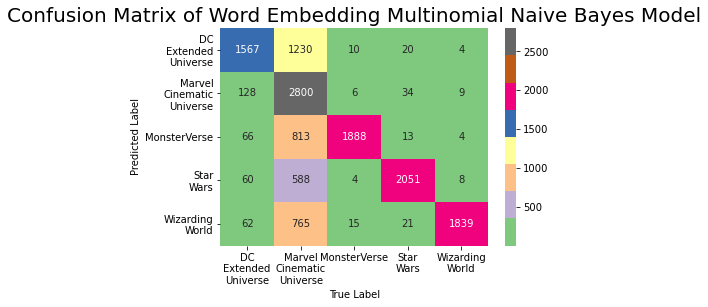

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
                           precision    recall  f1-score   support

     DC Extended Universe       0.83      0.55      0.66      2831
Marvel Cinematic Universe       0.45      0.94      0.61      2977
             MonsterVerse       0.98      0.68      0.80      2784
                Star Wars       0.96      0.76      0.85      2711
          Wizarding World       0.99      0.68      0.81      2702

                 accuracy                           0.72     14005
                macro avg       0.84      0.72      0.75     14005
             weighted avg       0.84      0.72      0.74     14005

CPU times: total: 406 ms
Wall time: 590 ms


In [92]:
%%time
we_multi_naive_bayes_model = MultinomialNB()
we_multi_naive_bayes_model, score_we_mnb = evaluate_model(X_train_emb_glv_scaled, y_train_emb_glv, X_valid_emb_glv_scaled, y_valid_emb_glv, classes, 
                                         we_multi_naive_bayes_model, "Word Embedding Multinomial Naive Bayes", "we_glv_multi_naive_bayes_model.pkl", fresh_load=False)

In [93]:
%%time
test_acc_scr_we_mnb, df_rottentomatoes_reviews = test_wrd_emb_model(we_multi_naive_bayes_model, "Word embedded Multinomial Naive Bayes Model", "we_mnb", 
                                                                df_rottentomatoes_reviews, min_max_scaler.transform(X_test_emb_gv))

Test Accuracy Score of Word embedded Multinomial Naive Bayes Model Model created using lemmatized word embedding vector is:
 0.720754716981132
CPU times: total: 0 ns
Wall time: 7.98 ms


In [94]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

# <font color='orange'>  <center> Glove Word Embedding Support Vector Classifier

Train Accuracy Score of Word Embedding Support Vector Classifier model created using stemmed tf_idf vector is:
 0.907736091560071
------------------------------------------------------------------------------------------------------------------------
Validation Accuracy Score of Word Embedding Support Vector Classifier model created using stemmed tf_idf vector is:
 0.8744019992859693
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:


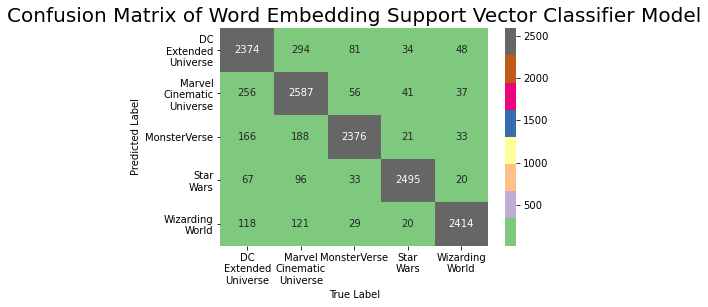

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
                           precision    recall  f1-score   support

     DC Extended Universe       0.80      0.84      0.82      2831
Marvel Cinematic Universe       0.79      0.87      0.83      2977
             MonsterVerse       0.92      0.85      0.89      2784
                Star Wars       0.96      0.92      0.94      2711
          Wizarding World       0.95      0.89      0.92      2702

                 accuracy                           0.87     14005
                macro avg       0.88      0.87      0.88     14005
             weighted avg       0.88      0.87      0.88     14005

CPU times: total: 3min 47s
Wall time: 3min 49s


In [95]:
%%time
we_svc_model = SVC(kernel='rbf')
we_svc_model, score_we_svc = evaluate_model(X_train_emb_glv, y_train_emb_glv, X_valid_emb_glv, y_valid_emb_glv, classes, 
                                         we_svc_model, "Word Embedding Support Vector Classifier", "we_glv_svc_model.pkl", fresh_load=False)

In [96]:
%%time
test_acc_scr_we_svc, df_rottentomatoes_reviews = test_wrd_emb_model(we_svc_model, "Word Embedding Support Vector Classifier", "we_svc", 
                                                                df_rottentomatoes_reviews, X_test_emb_gv)

Test Accuracy Score of Word Embedding Support Vector Classifier Model created using lemmatized word embedding vector is:
 0.879245283018868
CPU times: total: 844 ms
Wall time: 841 ms


In [97]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

# <font color='orange'>  <center> Glove Word Embedding K-Nearest Neighbor(KNN)

Train Accuracy Score of Word Embedding K-Nearest Neighbor(KNN) model created using stemmed tf_idf vector is:
 0.8687802191076566
------------------------------------------------------------------------------------------------------------------------
Validation Accuracy Score of Word Embedding K-Nearest Neighbor(KNN) model created using stemmed tf_idf vector is:
 0.8155658693323813
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:


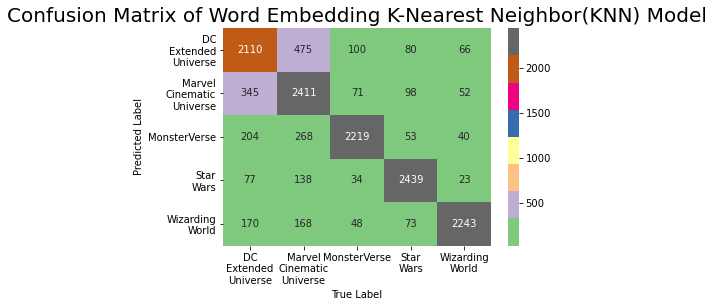

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
                           precision    recall  f1-score   support

     DC Extended Universe       0.73      0.75      0.74      2831
Marvel Cinematic Universe       0.70      0.81      0.75      2977
             MonsterVerse       0.90      0.80      0.84      2784
                Star Wars       0.89      0.90      0.89      2711
          Wizarding World       0.93      0.83      0.88      2702

                 accuracy                           0.82     14005
                macro avg       0.83      0.82      0.82     14005
             weighted avg       0.82      0.82      0.82     14005

CPU times: total: 2min 28s
Wall time: 57.6 s


In [98]:
%%time
we_knn_model = KNeighborsClassifier(5)
we_knn_model, score_we_knn = evaluate_model(X_train_emb_glv, y_train_emb_glv, X_valid_emb_glv, y_valid_emb_glv, classes, 
                                         we_knn_model, "Word Embedding K-Nearest Neighbor(KNN)", "we_glv_knn_model.pkl", fresh_load=False)

In [99]:
%%time
test_acc_scr_we_knn, df_rottentomatoes_reviews = test_wrd_emb_model(we_knn_model, "Word Embedding K-Nearest Neighbor(KNN)", "we_knn", 
                                                                df_rottentomatoes_reviews, X_test_emb_gv)

Test Accuracy Score of Word Embedding K-Nearest Neighbor(KNN) Model created using lemmatized word embedding vector is:
 0.7509433962264151
CPU times: total: 609 ms
Wall time: 239 ms


In [100]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

# <font color='orange'>  <center> Glove Word Embedding Random Forest Classifier

Train Accuracy Score of Word Embedding Random Forest Classifier model created using stemmed tf_idf vector is:
 0.9937266662586449
------------------------------------------------------------------------------------------------------------------------
Validation Accuracy Score of Word Embedding Random Forest Classifier model created using stemmed tf_idf vector is:
 0.8447697250981793
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:


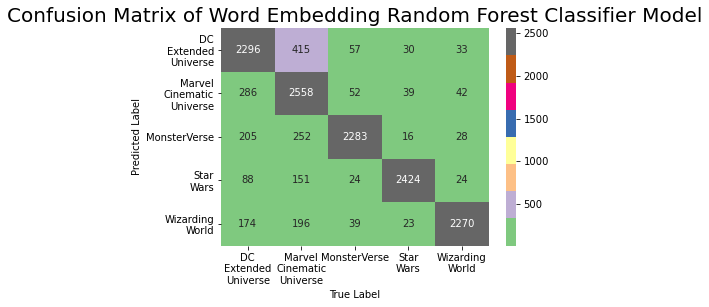

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
                           precision    recall  f1-score   support

     DC Extended Universe       0.75      0.81      0.78      2831
Marvel Cinematic Universe       0.72      0.86      0.78      2977
             MonsterVerse       0.93      0.82      0.87      2784
                Star Wars       0.96      0.89      0.92      2711
          Wizarding World       0.95      0.84      0.89      2702

                 accuracy                           0.84     14005
                macro avg       0.86      0.84      0.85     14005
             weighted avg       0.86      0.84      0.85     14005

CPU times: total: 4 s
Wall time: 5.85 s


In [101]:
%%time
we_rndm_frst_model = RandomForestClassifier(n_estimators=200)
we_rndm_frst_model, score_we_rfc = evaluate_model(X_train_emb_glv, y_train_emb_glv, X_valid_emb_glv, y_valid_emb_glv, classes, 
                                         we_rndm_frst_model, "Word Embedding Random Forest Classifier", "we_glv_rndm_frst_model.pkl", fresh_load=False)

In [102]:
%%time
test_acc_scr_we_rfc, df_rottentomatoes_reviews = test_wrd_emb_model(we_rndm_frst_model, "Word Embedding Random Forest Classifier", "we_rfc", 
                                                                df_rottentomatoes_reviews, X_test_emb_gv)

Test Accuracy Score of Word Embedding Random Forest Classifier Model created using lemmatized word embedding vector is:
 0.8566037735849057
CPU times: total: 46.9 ms
Wall time: 44.9 ms


In [103]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

# <font color='orange'>  <center> Glove Word Embedding XGB Classifier

------------------------------------------------------------------------------------------------------------------------
Train Accuracy Score of Word Embedding XGB Classifier model created using stemmed tf_idf vector is:
 0.9911867311340964
------------------------------------------------------------------------------------------------------------------------
Validation Accuracy Score of Word Embedding XGB Classifier model created using stemmed tf_idf vector is:
 0.8565512317029632
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:


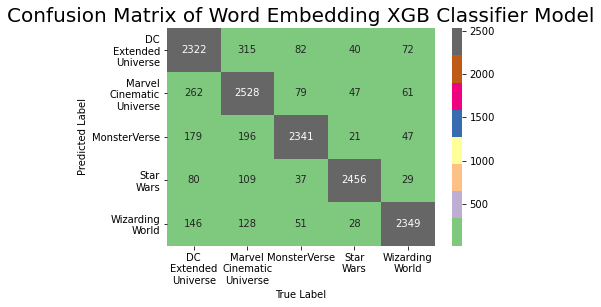

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
                           precision    recall  f1-score   support

     DC Extended Universe       0.78      0.82      0.80      2831
Marvel Cinematic Universe       0.77      0.85      0.81      2977
             MonsterVerse       0.90      0.84      0.87      2784
                Star Wars       0.95      0.91      0.93      2711
          Wizarding World       0.92      0.87      0.89      2702

                 accuracy                           0.86     14005
                macro avg       0.86      0.86      0.86     14005
             weighted avg       0.86      0.86      0.86     14005

CPU times: total: 1h 42s
Wall time: 7min 51s


In [142]:
%%time
we_xgb_model = xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc')
we_xgb_model, score_we_xgb = evaluate_model(X_train_emb_glv, y_train_emb_glv, X_valid_emb_glv, y_valid_emb_glv, classes, 
                                         we_xgb_model, "Word Embedding XGB Classifier", "we_glv_xgb_model.pkl", fresh_load=True)

In [143]:
%%time
test_acc_scr_we_xgb, df_rottentomatoes_reviews = test_wrd_emb_model(we_xgb_model, "Word Embedding XGB Classifier", "we_xgb", 
                                                                df_rottentomatoes_reviews, X_test_emb_gv)

Test Accuracy Score of Word Embedding XGB Classifier Model created using lemmatized word embedding vector is:
 0.8528301886792453
CPU times: total: 93.8 ms
Wall time: 11.9 ms


In [144]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

In [157]:
score_we = list(deepflatten([score_we_mnb, test_acc_scr_we_mnb, score_we_svc, test_acc_scr_we_svc,
                                 score_we_knn, test_acc_scr_we_knn, score_we_rfc,test_acc_scr_we_rfc,
                                 score_we_xgb, test_acc_scr_we_xgb], depth=1))
score_we = [score_we]

In [158]:
df_score_we = pd.DataFrame(score_we)
df_score_we.columns = pd.MultiIndex.from_product([['MNB Accuracy', 'SVC Accuracy', 'KNN Accuracy', 'RFC Accuracy', 'XGB Accuracy'], ['Train','Validate','Test']])
df_score_we = df_score_we.set_index([['Word Embedding Glove']])
df_score_we[df_score_we.columns] = df_score_we[df_score_we.columns].applymap(lambda x: x*100)
df_score_we[df_score_we.columns] = df_score_we[df_score_we.columns].applymap("{0:.2f}%".format)
df_score_we

MNB Accuracy                  SVC Accuracy           \
                            Train Validate    Test        Train Validate   
Word Embedding Glove       71.71%   72.44%  72.08%       90.77%   87.44%   

                             KNN Accuracy                  RFC Accuracy  \
                        Test        Train Validate    Test        Train   
Word Embedding Glove  87.92%       86.88%   81.56%  75.09%       99.37%   

                                      XGB Accuracy                   
                     Validate    Test        Train Validate    Test  
Word Embedding Glove   84.48%  85.66%       99.12%   85.66%  85.28%

# <font color='orange'>  <center> Word2Vec Word Embedding

## <font color='orange'> Transforming lemmatized text into vectors using Pre-trained Word2Vec model (Google News Negative 300)

In [109]:
%%time
w2v_vectorizer = Word2VecVectorizer()

X_train_emb_w2v = w2v_vectorizer.fit_transform(train_emb.full_text)
y_train_emb_w2v = train_emb.label_id

X_valid_emb_w2v = w2v_vectorizer.transform(valid_emb.full_text)
y_valid_emb_w2v = valid_emb.label_id

Loading in word vectors...
Finished loading in word vectors
Number of samples with no words found: 430 / 32678
Number of samples with no words found: 164 / 14005
CPU times: total: 40.1 s
Wall time: 54.2 s


In [110]:
list_f = sorted(glob.glob("output/final_output/df_rottentomatoes_reviews_predicted*"), key=os.path.getmtime)
output_file_name = list_f[0]
df_rottentomatoes_reviews = pd.read_csv(output_file_name)

In [111]:
%%time
X_test_emb_w2v = []
classes = {0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
for i in df_rottentomatoes_reviews.index:
    test_text = df_rottentomatoes_reviews["review"][i]
    test_text = preprocess_doc(test_text, stem = False, lemma = True, stop_wrds = True, selected_tags = selected_tags)
    X_test_emb_w2v.append(test_text)
X_test_emb_w2v = [" ".join(l) for l in X_test_emb_w2v]
X_test_emb_w2v = pd.Series(X_test_emb_w2v)
X_test_emb_w2v[:2]

CPU times: total: 10.9 s
Wall time: 11.2 s


0    godzilla monster thing people love see child g...
1    movie horror maestro comedy script way movie o...
dtype: object

In [112]:
X_test_emb_w2v = w2v_vectorizer.transform(X_test_emb_w2v)
Y_test_emb_w2v = df_rottentomatoes_reviews['y_true']

Number of samples with no words found: 0 / 265


# <font color='orange'>  <center> Word2Vec Word Embedding Multinomial Naive Bayes model

In [113]:
%%time
min_max_scaler = MinMaxScaler()
X_train_emb_w2v_scaled = min_max_scaler.fit_transform(X_train_emb_w2v)
X_valid_emb_w2v_scaled = min_max_scaler.transform(X_valid_emb_w2v)

CPU times: total: 156 ms
Wall time: 142 ms


Train Accuracy Score of Word2Vec Word Embedding Multinomial Naive Bayes model created using stemmed tf_idf vector is:
 0.5959667054287288
------------------------------------------------------------------------------------------------------------------------
Validation Accuracy Score of Word2Vec Word Embedding Multinomial Naive Bayes model created using stemmed tf_idf vector is:
 0.6016422706176365
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:


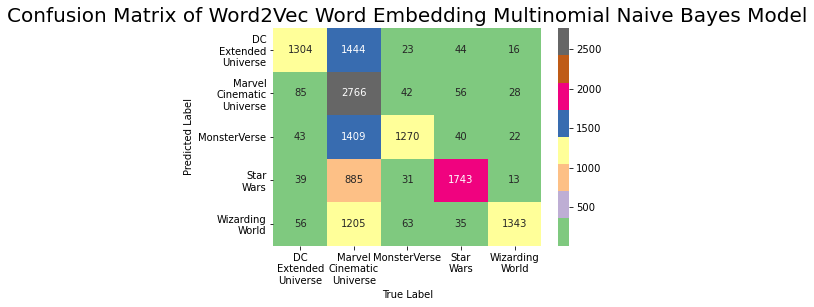

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
                           precision    recall  f1-score   support

     DC Extended Universe       0.85      0.46      0.60      2831
Marvel Cinematic Universe       0.36      0.93      0.52      2977
             MonsterVerse       0.89      0.46      0.60      2784
                Star Wars       0.91      0.64      0.75      2711
          Wizarding World       0.94      0.50      0.65      2702

                 accuracy                           0.60     14005
                macro avg       0.79      0.60      0.62     14005
             weighted avg       0.78      0.60      0.62     14005

CPU times: total: 422 ms
Wall time: 370 ms


In [114]:
%%time
we_w2v_multi_naive_bayes_model = MultinomialNB()
we_w2v_multi_naive_bayes_model, score_we_w2v_mnb = evaluate_model(X_train_emb_w2v_scaled, y_train_emb_w2v, X_valid_emb_w2v_scaled, y_valid_emb_w2v, classes, 
                                         we_w2v_multi_naive_bayes_model, "Word2Vec Word Embedding Multinomial Naive Bayes", "we_w2v_multi_naive_bayes_model.pkl", fresh_load=False)

In [115]:
%%time
test_acc_scr_we_w2v_mnb, df_rottentomatoes_reviews = test_wrd_emb_model(we_w2v_multi_naive_bayes_model, "Word embedded Multinomial Naive Bayes Model", "we_w2v_mnb", 
                                                                df_rottentomatoes_reviews, min_max_scaler.transform(X_test_emb_w2v))

Test Accuracy Score of Word embedded Multinomial Naive Bayes Model Model created using lemmatized word embedding vector is:
 0.660377358490566
CPU times: total: 0 ns
Wall time: 4.99 ms


In [116]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

# <font color='orange'>  <center> Word2Vec Word Embedding Support Vector Classifier

Train Accuracy Score of Word2Vec Word Embedding Support Vector Classifier model created using stemmed tf_idf vector is:
 0.8864067568394639
------------------------------------------------------------------------------------------------------------------------
Validation Accuracy Score of Word2Vec Word Embedding Support Vector Classifier model created using stemmed tf_idf vector is:
 0.8178507675830061
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:


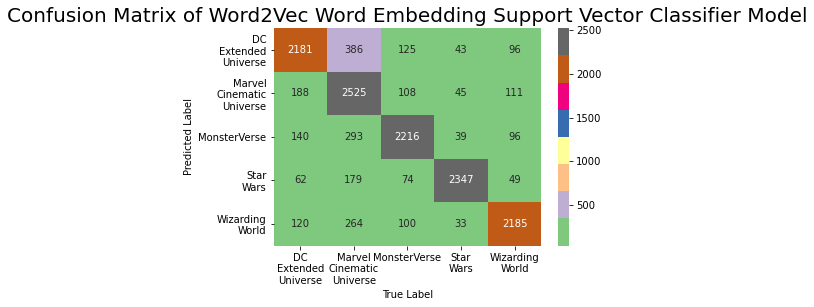

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
                           precision    recall  f1-score   support

     DC Extended Universe       0.81      0.77      0.79      2831
Marvel Cinematic Universe       0.69      0.85      0.76      2977
             MonsterVerse       0.84      0.80      0.82      2784
                Star Wars       0.94      0.87      0.90      2711
          Wizarding World       0.86      0.81      0.83      2702

                 accuracy                           0.82     14005
                macro avg       0.83      0.82      0.82     14005
             weighted avg       0.83      0.82      0.82     14005

CPU times: total: 5min 43s
Wall time: 5min 43s


In [117]:
%%time
we_w2v_svc_model = SVC(kernel='rbf')
we_w2v_svc_model, score_we_w2v_svc = evaluate_model(X_train_emb_w2v, y_train_emb_w2v, X_valid_emb_w2v, y_valid_emb_w2v, classes, 
                                         we_w2v_svc_model, "Word2Vec Word Embedding Support Vector Classifier", "we_w2v_svc_model.pkl", fresh_load=False)

In [118]:
%%time
test_acc_scr_we_w2v_svc, df_rottentomatoes_reviews = test_wrd_emb_model(we_w2v_svc_model, "Word2Vec Word Embedding Support Vector Classifier", "we_w2v_svc", 
                                                                df_rottentomatoes_reviews, X_test_emb_w2v)

Test Accuracy Score of Word2Vec Word Embedding Support Vector Classifier Model created using lemmatized word embedding vector is:
 0.8339622641509434
CPU times: total: 1.22 s
Wall time: 1.2 s


In [119]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

# <font color='orange'>  <center> Word2Vec Word Embedding K-Nearest Neighbor(KNN)

Train Accuracy Score of Word2Vec Word Embedding K-Nearest Neighbor(KNN) model created using stemmed tf_idf vector is:
 0.7983658730644471
------------------------------------------------------------------------------------------------------------------------
Validation Accuracy Score of Word2Vec Word Embedding K-Nearest Neighbor(KNN) model created using stemmed tf_idf vector is:
 0.7188147090324885
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:


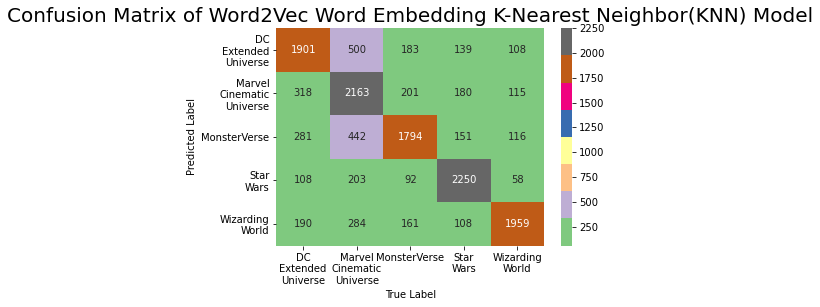

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
                           precision    recall  f1-score   support

     DC Extended Universe       0.68      0.67      0.68      2831
Marvel Cinematic Universe       0.60      0.73      0.66      2977
             MonsterVerse       0.74      0.64      0.69      2784
                Star Wars       0.80      0.83      0.81      2711
          Wizarding World       0.83      0.73      0.77      2702

                 accuracy                           0.72     14005
                macro avg       0.73      0.72      0.72     14005
             weighted avg       0.73      0.72      0.72     14005

CPU times: total: 2min 31s
Wall time: 1min


In [120]:
%%time
we_w2v_knn_model = KNeighborsClassifier(5)
we_w2v_knn_model, score_we_w2v_knn = evaluate_model(X_train_emb_w2v, y_train_emb_w2v, X_valid_emb_w2v, y_valid_emb_w2v, classes, 
                                         we_w2v_knn_model, "Word2Vec Word Embedding K-Nearest Neighbor(KNN)", "we_w2v_knn_model.pkl", fresh_load=False)

In [121]:
%%time
test_acc_scr_we_w2v_knn, df_rottentomatoes_reviews = test_wrd_emb_model(we_w2v_knn_model, "Word2Vec Word Embedding K-Nearest Neighbor(KNN)", "we_w2v_knn", 
                                                                df_rottentomatoes_reviews, X_test_emb_w2v)

Test Accuracy Score of Word2Vec Word Embedding K-Nearest Neighbor(KNN) Model created using lemmatized word embedding vector is:
 0.6792452830188679
CPU times: total: 656 ms
Wall time: 246 ms


In [122]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

# <font color='orange'>  <center> Word2Vec Word Embedding Random Forest Classifier

Train Accuracy Score of Word2Vec Word Embedding Random Forest Classifier model created using stemmed tf_idf vector is:
 0.9831997062243711
------------------------------------------------------------------------------------------------------------------------
Validation Accuracy Score of Word2Vec Word Embedding Random Forest Classifier model created using stemmed tf_idf vector is:
 0.7605141021063906
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:


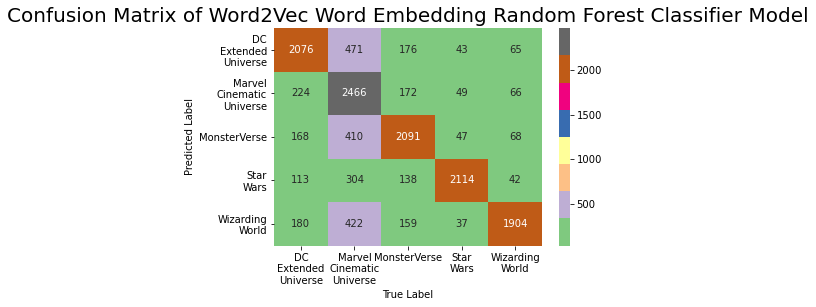

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
                           precision    recall  f1-score   support

     DC Extended Universe       0.75      0.73      0.74      2831
Marvel Cinematic Universe       0.61      0.83      0.70      2977
             MonsterVerse       0.76      0.75      0.76      2784
                Star Wars       0.92      0.78      0.85      2711
          Wizarding World       0.89      0.70      0.79      2702

                 accuracy                           0.76     14005
                macro avg       0.79      0.76      0.77     14005
             weighted avg       0.78      0.76      0.76     14005

CPU times: total: 4.22 s
Wall time: 5.98 s


In [123]:
%%time
we_w2v_rndm_frst_model = RandomForestClassifier(n_estimators=200)
we_w2v_rndm_frst_model, score_we_w2v_rfc = evaluate_model(X_train_emb_w2v, y_train_emb_w2v, X_valid_emb_w2v, y_valid_emb_w2v, classes, 
                                         we_w2v_rndm_frst_model, "Word2Vec Word Embedding Random Forest Classifier", "we_w2v_rndm_frst_model.pkl", fresh_load=False)

In [124]:
%%time
test_acc_scr_we_w2v_rfc, df_rottentomatoes_reviews = test_wrd_emb_model(we_w2v_rndm_frst_model, "Word2Vec Word Embedding Random Forest Classifier", "we_w2v_rfc", 
                                                                df_rottentomatoes_reviews, X_test_emb_w2v)

Test Accuracy Score of Word2Vec Word Embedding Random Forest Classifier Model created using lemmatized word embedding vector is:
 0.7396226415094339
CPU times: total: 31.2 ms
Wall time: 44.9 ms


In [125]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

# <font color='orange'>  <center> Word2Vec Word Embedding XGB Classifier

------------------------------------------------------------------------------------------------------------------------
Train Accuracy Score of Word2Vec Word Embedding XGB Classifier model created using stemmed tf_idf vector is:
 0.9737132015423221
------------------------------------------------------------------------------------------------------------------------
Validation Accuracy Score of Word2Vec Word Embedding XGB Classifier model created using stemmed tf_idf vector is:
 0.7778650481970725
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:


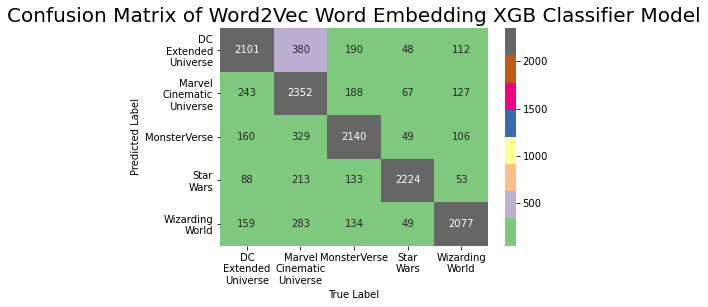

{0: 'DC Extended Universe', 1: 'Marvel Cinematic Universe', 2: 'MonsterVerse', 3: 'Star Wars', 4: 'Wizarding World'}
------------------------------------------------------------------------------------------------------------------------
                           precision    recall  f1-score   support

     DC Extended Universe       0.76      0.74      0.75      2831
Marvel Cinematic Universe       0.66      0.79      0.72      2977
             MonsterVerse       0.77      0.77      0.77      2784
                Star Wars       0.91      0.82      0.86      2711
          Wizarding World       0.84      0.77      0.80      2702

                 accuracy                           0.78     14005
                macro avg       0.79      0.78      0.78     14005
             weighted avg       0.79      0.78      0.78     14005

CPU times: total: 48min 33s
Wall time: 6min 34s


In [147]:
%%time
we_w2v_xgb_model = xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,#8
        use_label_encoder=False,
        eval_metric='auc')
we_w2v_xgb_model, score_we_w2v_xgb = evaluate_model(X_train_emb_w2v, y_train_emb_w2v, X_valid_emb_w2v, y_valid_emb_w2v, classes, 
                                         we_w2v_xgb_model, "Word2Vec Word Embedding XGB Classifier", "we_w2v_xgb_model.pkl", fresh_load=True)

In [148]:
%%time
test_acc_scr_we_w2v_xgb, df_rottentomatoes_reviews = test_wrd_emb_model(we_w2v_xgb_model, "Word2Vec Word Embedding XGB Classifier", "we_w2v_xgb", 
                                                                df_rottentomatoes_reviews, X_test_emb_w2v)

Test Accuracy Score of Word2Vec Word Embedding XGB Classifier Model created using lemmatized word embedding vector is:
 0.7773584905660378
CPU times: total: 78.1 ms
Wall time: 10.1 ms


In [149]:
df_rottentomatoes_reviews.to_csv(output_file_name, index = False)

In [150]:
score_we_w2v = list(deepflatten([score_we_w2v_mnb, test_acc_scr_we_w2v_mnb, score_we_w2v_svc, test_acc_scr_we_w2v_svc,
                                 score_we_w2v_knn, test_acc_scr_we_w2v_knn, score_we_w2v_rfc,test_acc_scr_we_w2v_rfc,
                                 score_we_w2v_xgb, test_acc_scr_we_w2v_xgb], depth=1))
score_we_w2v = [score_we_w2v]

In [151]:
df_score_we_w2v = pd.DataFrame(score_we_w2v)
df_score_we_w2v.columns = pd.MultiIndex.from_product([['MNB Accuracy', 'SVC Accuracy', 'KNN Accuracy', 'RFC Accuracy', 'XGB Accuracy'], ['Train','Validate','Test']])
df_score_we_w2v = df_score_we_w2v.set_index([['Word Embedding Word2Vec']])
df_score_we_w2v[df_score_we_w2v.columns] = df_score_we_w2v[df_score_we_w2v.columns].applymap(lambda x: x*100)
df_score_we_w2v[df_score_we_w2v.columns] = df_score_we_w2v[df_score_we_w2v.columns].applymap("{0:.2f}%".format)
df_score_we_w2v

MNB Accuracy                  SVC Accuracy           \
                               Train Validate    Test        Train Validate   
Word Embedding Word2Vec       59.60%   60.16%  66.04%       88.64%   81.79%   

                                KNN Accuracy                  RFC Accuracy  \
                           Test        Train Validate    Test        Train   
Word Embedding Word2Vec  83.40%       79.84%   71.88%  67.92%       98.32%   

                                         XGB Accuracy                   
                        Validate    Test        Train Validate    Test  
Word Embedding Word2Vec   76.05%  73.96%       97.37%   77.79%  77.74%

In [152]:
final_accuracy_df = pd.concat([df_score, df_score_we, df_score_we_w2v])
final_accuracy_df.to_csv("output/final_accuracy_final.csv")

In [159]:
def highlight_cols(x):
    df = x.copy()
    df.loc[:, :] = 'background-color: black'
    df[[('MNB Accuracy', 'Test'), ('KNN Accuracy', 'Test'), ('RFC Accuracy', 'Test')]] = 'background-color: blue'
    df[[('SVC Accuracy', 'Test'), ('XGB Accuracy', 'Test')]] = 'background-color: green'
    return df 

In [160]:
display(final_accuracy_df.style.apply(highlight_cols, axis = None))

# <font color='orange'>  <center> Clustering

In [181]:
'''Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(X_sv)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()'''

"Sum_of_squared_distances = []\nK = range(2,10)\nfor k in K:\n    km = KMeans(n_clusters=k, max_iter=200, n_init=10)\n    km = km.fit(X_sv)\n    Sum_of_squared_distances.append(km.inertia_)\nplt.plot(K, Sum_of_squared_distances, 'bx-')\nplt.xlabel('k')\nplt.ylabel('Sum_of_squared_distances')\nplt.title('Elbow Method For Optimal k')\nplt.show()"

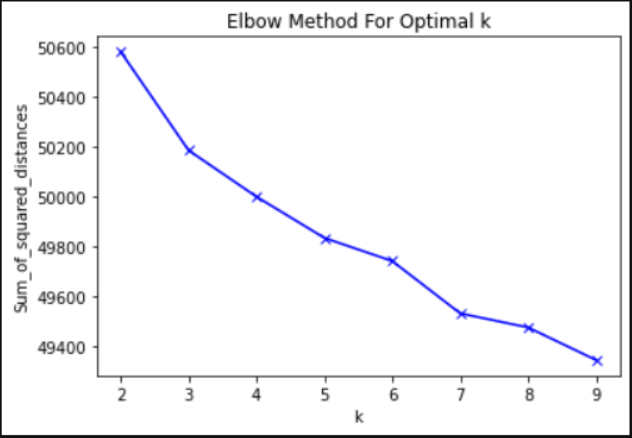

In [182]:
classes

{0: 'DC Extended Universe',
 1: 'Marvel Cinematic Universe',
 2: 'MonsterVerse',
 3: 'Star Wars',
 4: 'Wizarding World'}

### Elbow point appears at 5 and 7 so lets take k = 7

In [214]:
%%time
true_k = 5
title = df_vectorization['label']
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(X_sv)
labels=model.labels_
universe_cl=pd.DataFrame(list(zip(title,labels)),columns=['title','cluster'])
print(universe_cl.sort_values(by=['cluster']))

                           title  cluster
0      Marvel Cinematic Universe        0
27877            Wizarding World        0
27874       DC Extended Universe        0
27872               MonsterVerse        0
27870                  Star Wars        0
...                          ...      ...
20344                  Star Wars        4
26933                  Star Wars        4
20346                  Star Wars        4
25796                  Star Wars        4
26102                  Star Wars        4

[47348 rows x 2 columns]
CPU times: total: 7min 49s
Wall time: 1min 43s


Cluster: 0
Titles


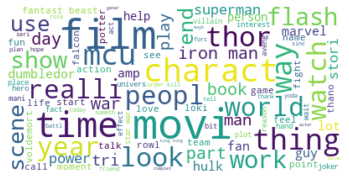

Cluster: 1
Titles


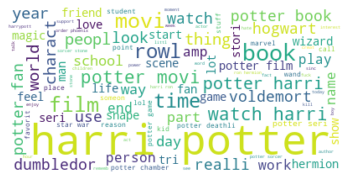

Cluster: 2
Titles


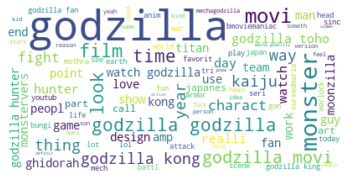

Cluster: 3
Titles


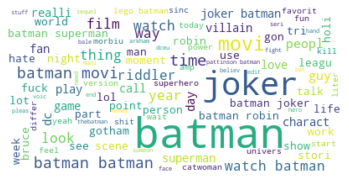

Cluster: 4
Titles


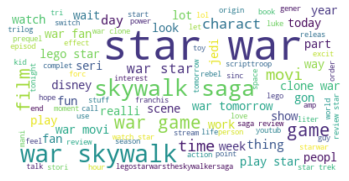

In [215]:
result={'cluster':labels,'reviews':list_stemmed_data}
result=pd.DataFrame(result)
for k in range(0,true_k):
    s=result[result.cluster==k]
    text=s['reviews'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    print('Cluster: {}'.format(k))
    print('Titles')
    titles=universe_cl[universe_cl.cluster==k]['title']         
    #print(titles.to_string(index=False))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [216]:
for k in range(true_k):
    print("Value Counts for cluster = ", k)
    print(universe_cl[universe_cl.cluster == k].value_counts())
    print("========================================================")

Value Counts for cluster =  0
title                      cluster
Marvel Cinematic Universe  0          10039
DC Extended Universe       0           6336
Wizarding World            0           4885
Star Wars                  0           4067
MonsterVerse               0           3815
dtype: int64
Value Counts for cluster =  1
title                      cluster
Wizarding World            1          4185
Star Wars                  1            16
Marvel Cinematic Universe  1             6
DC Extended Universe       1             3
MonsterVerse               1             3
dtype: int64
Value Counts for cluster =  2
title                 cluster
MonsterVerse          2          5543
DC Extended Universe  2             1
Wizarding World       2             1
dtype: int64
Value Counts for cluster =  3
title                      cluster
DC Extended Universe       3          3215
Marvel Cinematic Universe  3            27
MonsterVerse               3            17
Wizarding World            3

In [217]:
%%time
sample_silhouette_values = silhouette_samples(X_sv, model.labels_)
print(f"Silhouette values:")
silhouette_values = []
for i in range(true_k):
    cluster_silhouette_values = sample_silhouette_values[model.labels_ == i]
    silhouette_values.append((i,
    cluster_silhouette_values.shape[0],
    cluster_silhouette_values.mean(),
    cluster_silhouette_values.min(),
    cluster_silhouette_values.max(),))
silhouette_values = sorted(silhouette_values, key=lambda tup: tup[2], reverse=True)
for s in silhouette_values:
    print(f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}")

Silhouette values:
    Cluster 1: Size:4213 | Avg:0.04 | Min:0.00 | Max: 0.17
    Cluster 4: Size:5173 | Avg:0.03 | Min:-0.00 | Max: 0.13
    Cluster 3: Size:3275 | Avg:0.02 | Min:-0.00 | Max: 0.09
    Cluster 2: Size:5545 | Avg:0.02 | Min:-0.01 | Max: 0.10
    Cluster 0: Size:29142 | Avg:0.00 | Min:-0.02 | Max: 0.01
CPU times: total: 1min 10s
Wall time: 1min 10s


In [231]:
import plotly.graph_objs as go

In [237]:
plotX = pd.DataFrame(X_sv.toarray())

In [239]:
plotX.head()

,0,1,2,3,4,5,6,7,8,9,...,77013,77014,77015,77016,77017,77018,77019,77020,77021,77022
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
